<a href="https://colab.research.google.com/github/Doberman12/diamondpricesprediction/blob/main/diamonds-price-prediction-ml-models-comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### importing libralies used in this project

In [148]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score




### Loading data

In [149]:
path = "/diamonds.csv"
#path = "D:\ML\diamonds.csv"
data = pd.read_csv(path, index_col = 0)

### Visualising the data

In [150]:
data.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


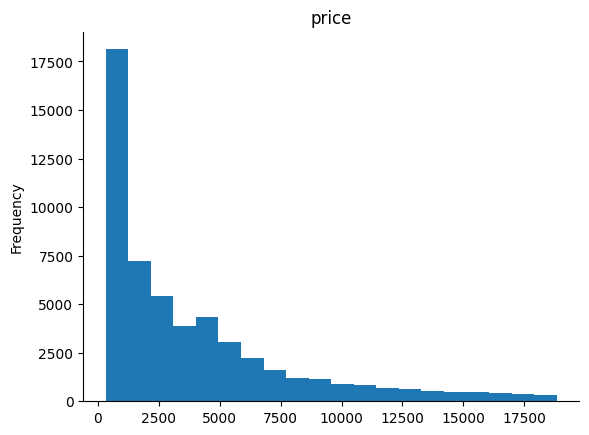

In [151]:
data['price'].plot(kind='hist', bins=20, title='price')
plt.gca().spines[['top', 'right',]].set_visible(False)

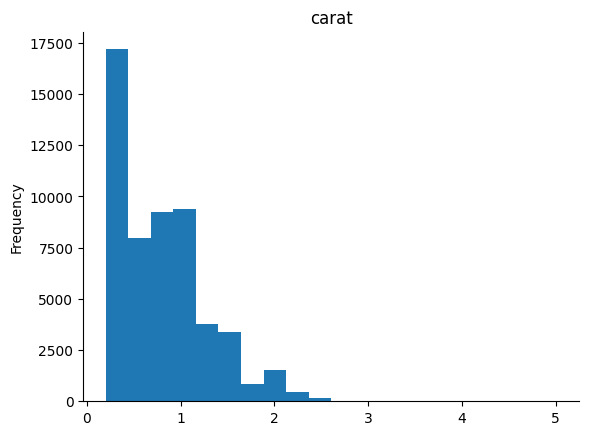

In [152]:
data['carat'].plot(kind='hist', bins=20, title='carat')
plt.gca().spines[['top', 'right',]].set_visible(False)

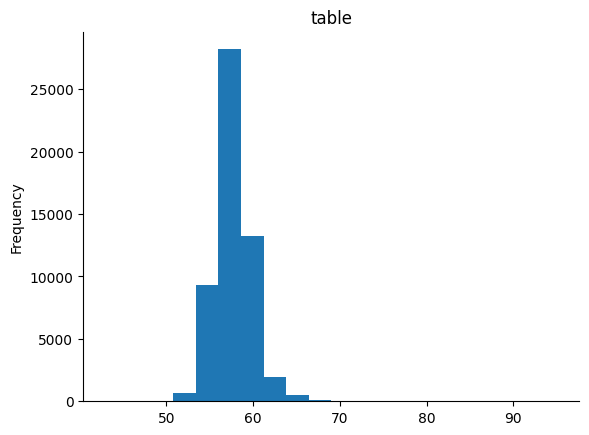

In [153]:
data['table'].plot(kind='hist', bins=20, title='table')
plt.gca().spines[['top', 'right',]].set_visible(False)

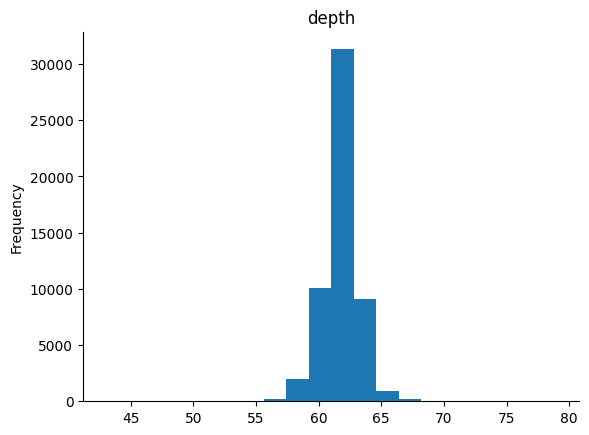

In [154]:
data['depth'].plot(kind='hist', bins=20, title='depth')
plt.gca().spines[['top', 'right',]].set_visible(False)

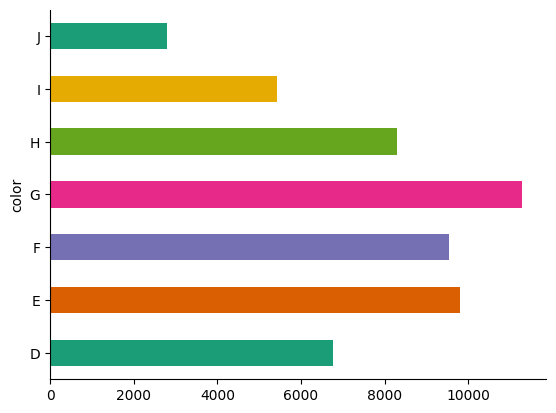

In [155]:
data.groupby('color').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

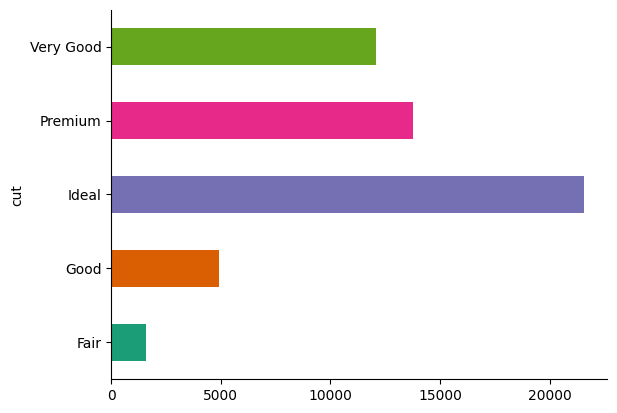

In [156]:
data.groupby('cut').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

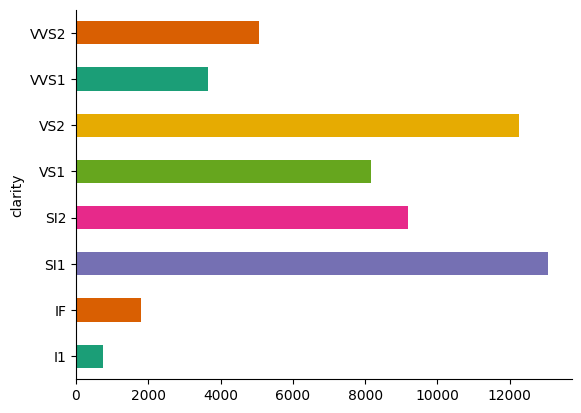

In [157]:
data.groupby('clarity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

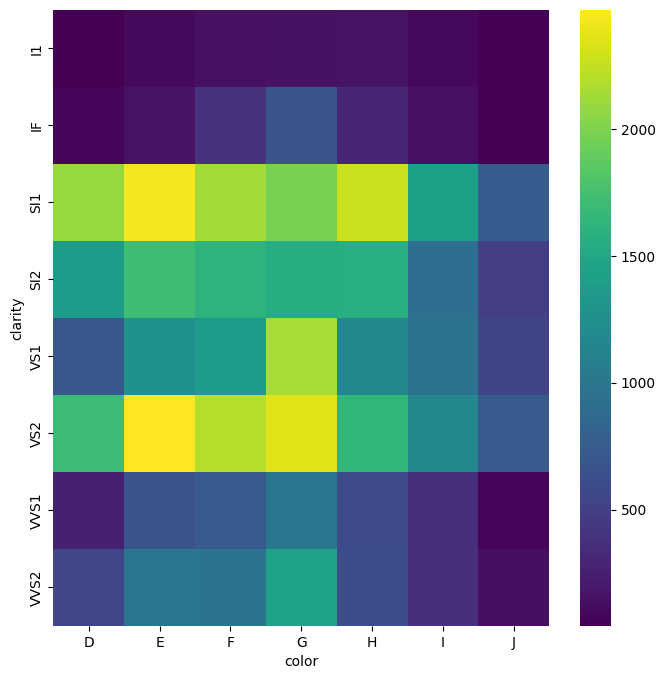

In [158]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['clarity'].value_counts()
    for x_label, grp in data.groupby('color')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('color')
_ = plt.ylabel('clarity')

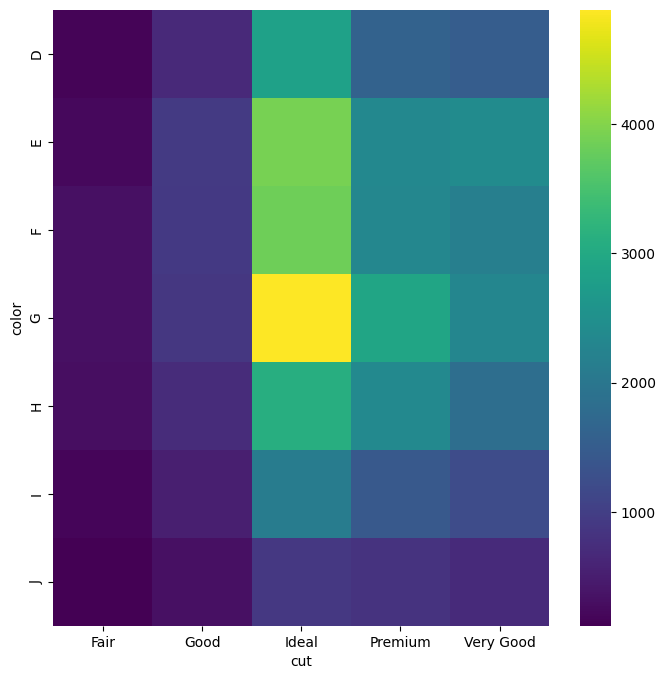

In [159]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['color'].value_counts()
    for x_label, grp in data.groupby('cut')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('cut')
_ = plt.ylabel('color')

### Removing outliers

In [160]:
num_cols = [col for col in data.columns if data[col].dtypes != 'O']

In [161]:
def drop_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - IQR * 1.5
    high = Q3 + IQR * 1.5
    new_data = data[(data[column] >= low) & (data[column] <= high)]
    return new_data

In [162]:
new_data = data.copy()
for col in num_cols:
    new_data = drop_outliers(new_data, col)

### Data with outliers Vs Data without outliers

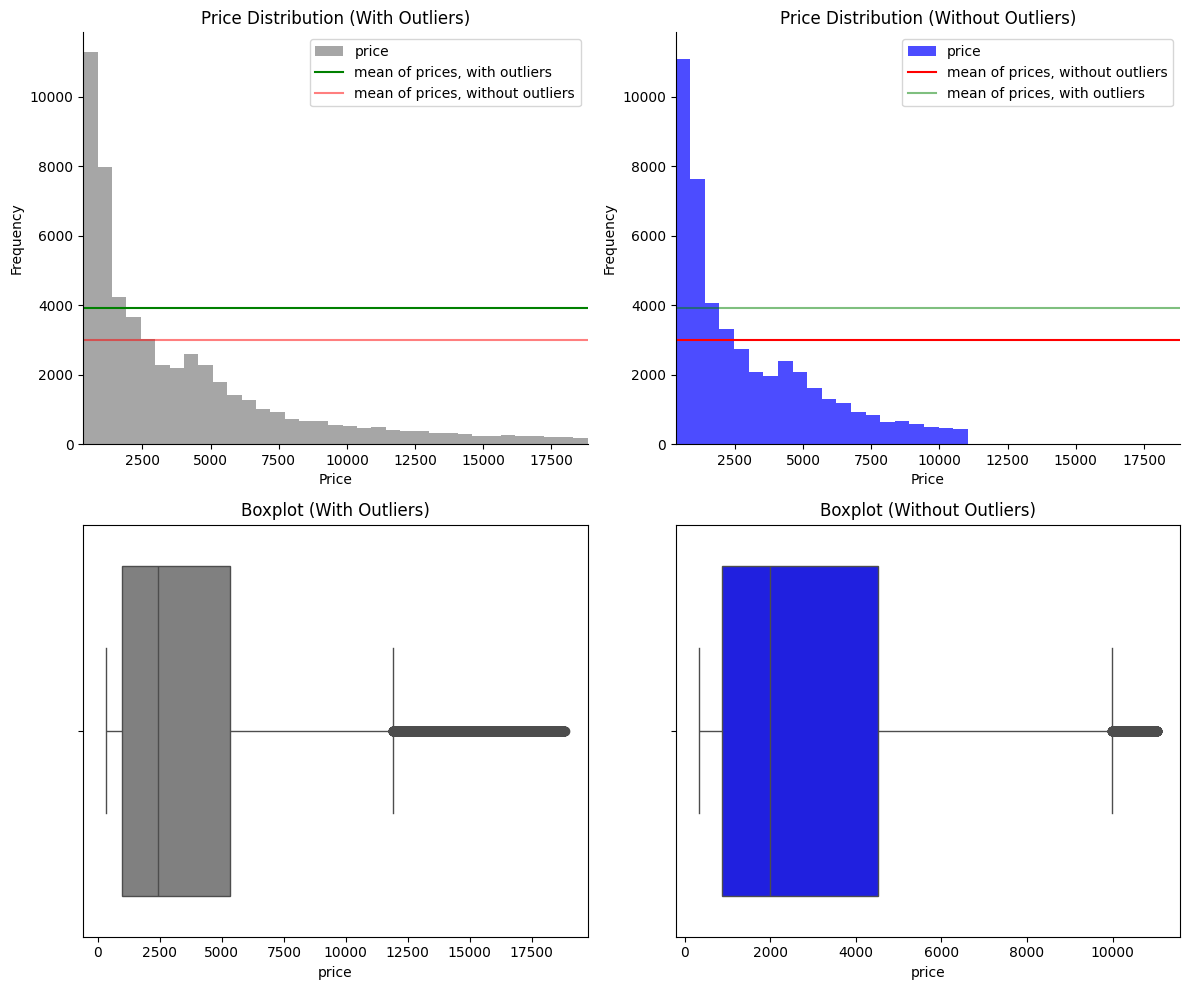

In [163]:
ig, ax = plt.subplots(2, 2, figsize=(12, 10))

data['price'].plot(kind='hist', bins=35, ax=ax[0, 0], color='gray', alpha=0.7)
ax[0, 0].set_title('Price Distribution (With Outliers)')
ax[0, 0].axhline(y=data['price'].mean(), color = 'green', label='mean of prices, with outliers')
ax[0, 0].axhline(y=new_data['price'].mean(), color = 'red', label='mean of prices, without outliers', alpha=0.5)
ax[0, 0].set_xlabel('Price')
ax[0, 0].spines[['top', 'right']].set_visible(False)

new_data['price'].plot(kind='hist', bins=20, ax=ax[0, 1], color='blue', alpha=0.7)
ax[0, 1].set_title('Price Distribution (Without Outliers)')
ax[0, 1].axhline(y=new_data['price'].mean(), color = 'red', label='mean of prices, without outliers')
ax[0, 1].axhline(y=data['price'].mean(), color = 'green', label='mean of prices, with outliers', alpha = 0.5)
ax[0, 1].set_xlabel('Price')
ax[0, 1].spines[['top', 'right']].set_visible(False)

x_min = min(data['price'].min(), new_data['price'].min())
x_max = max(data['price'].max(), new_data['price'].max())
y_min = 0
y_max = max(ax[0, 0].get_ylim()[1], ax[0,1].get_ylim()[1])

ax[0, 0].set_xlim(x_min, x_max)
ax[0, 1].set_xlim(x_min, x_max)

ax[0, 0].set_ylim(y_min, y_max)
ax[0, 1].set_ylim(y_min, y_max)

sns.boxplot(x=data['price'], ax=ax[1, 0], color='gray')
ax[1, 0].set_title("Boxplot (With Outliers)")

sns.boxplot(x=new_data['price'], ax=ax[1, 1], color='blue')
ax[1, 1].set_title("Boxplot (Without Outliers)")
plt.tight_layout()
ax[0, 1].legend()
ax[0, 0].legend()
plt.show()

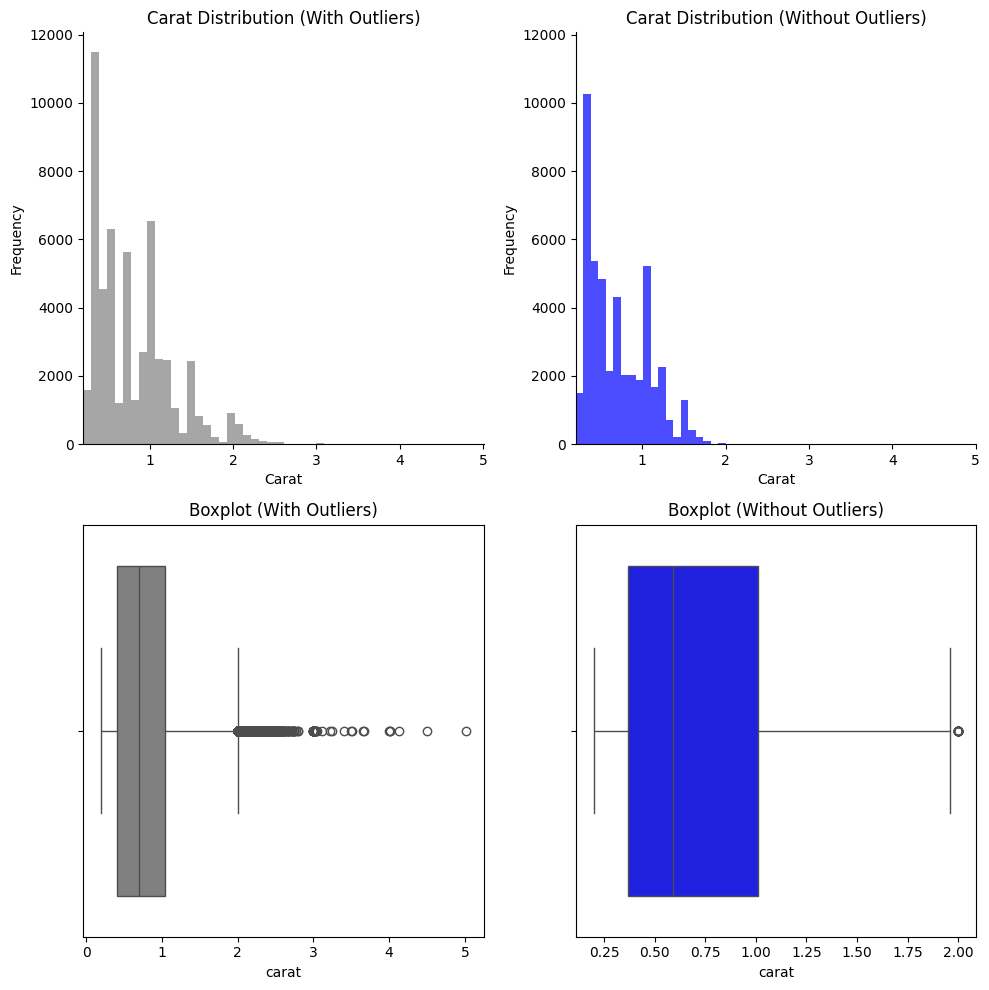

In [164]:
ig, ax = plt.subplots(2, 2, figsize=(10, 10))

data['carat'].plot(kind='hist', bins=50, ax=ax[0, 0], color='gray', alpha=0.7)
ax[0, 0].set_title('Carat Distribution (With Outliers)')
ax[0, 0].set_xlabel('Carat')  # Add x-axis label
ax[0, 0].spines[['top', 'right']].set_visible(False)

new_data['carat'].plot(kind='hist', bins=20, ax=ax[0, 1], color='blue', alpha=0.7)
ax[0, 1].set_title('Carat Distribution (Without Outliers)')
ax[0, 1].set_xlabel('Carat')  # Add x-axis label
ax[0, 1].spines[['top', 'right']].set_visible(False)

x_min = min(data['carat'].min(), new_data['carat'].min())
x_max = max(data['carat'].max(), new_data['carat'].max())
y_min = 0
y_max = max(ax[0, 0].get_ylim()[1], ax[0,1].get_ylim()[1])

ax[0, 0].set_xlim(x_min, x_max)
ax[0, 1].set_xlim(x_min, x_max)

ax[0, 0].set_ylim(y_min, y_max)
ax[0, 1].set_ylim(y_min, y_max)

sns.boxplot(x=data['carat'], ax=ax[1, 0], color='gray')
ax[1, 0].set_title("Boxplot (With Outliers)")

sns.boxplot(x=new_data['carat'], ax=ax[1, 1], color='blue')
ax[1, 1].set_title("Boxplot (Without Outliers)")
plt.tight_layout()
plt.show()

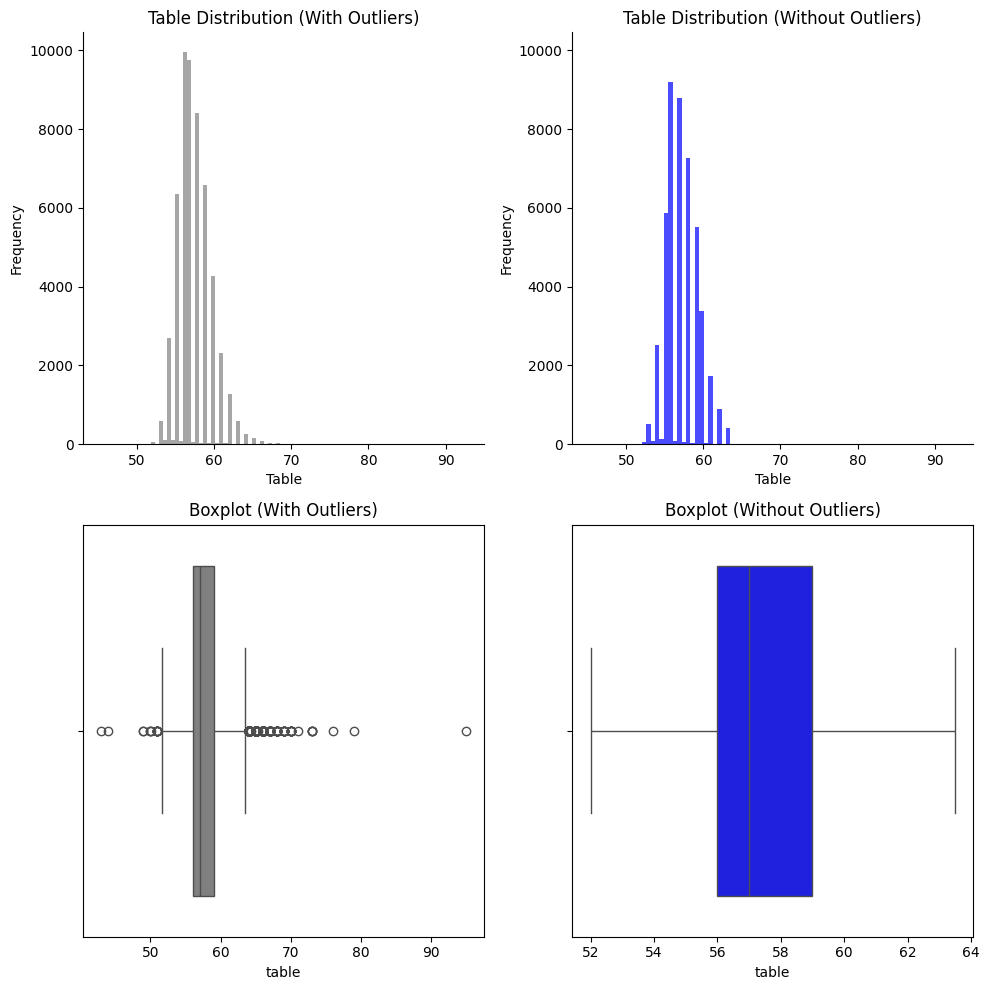

In [165]:
ig, ax = plt.subplots(2, 2, figsize=(10, 10))

data['table'].plot(kind='hist', bins=100, ax=ax[0, 0], color='gray', alpha=0.7)
ax[0, 0].set_title('Table Distribution (With Outliers)')
ax[0, 0].set_xlabel('Table')
ax[0, 0].spines[['top', 'right']].set_visible(False)

new_data['table'].plot(kind='hist', bins=20, ax=ax[0, 1], color='blue', alpha=0.7)
ax[0, 1].set_title('Table Distribution (Without Outliers)')
ax[0, 1].set_xlabel('Table')
ax[0, 1].spines[['top', 'right']].set_visible(False)

x_min = min(data['table'].min(), new_data['table'].min())
x_max = max(data['table'].max(), new_data['table'].max())
y_min = 0
y_max = max(ax[0, 0].get_ylim()[1], ax[0,1].get_ylim()[1])

ax[0, 0].set_xlim(x_min, x_max)
ax[0, 1].set_xlim(x_min, x_max)
ax[0, 0].set_ylim(y_min, y_max)
ax[0, 1].set_ylim(y_min, y_max)

sns.boxplot(x=data['table'], ax=ax[1, 0], color='gray')
ax[1, 0].set_title("Boxplot (With Outliers)")

sns.boxplot(x=new_data['table'], ax=ax[1, 1], color='blue')
ax[1, 1].set_title("Boxplot (Without Outliers)")
plt.tight_layout()
plt.show()

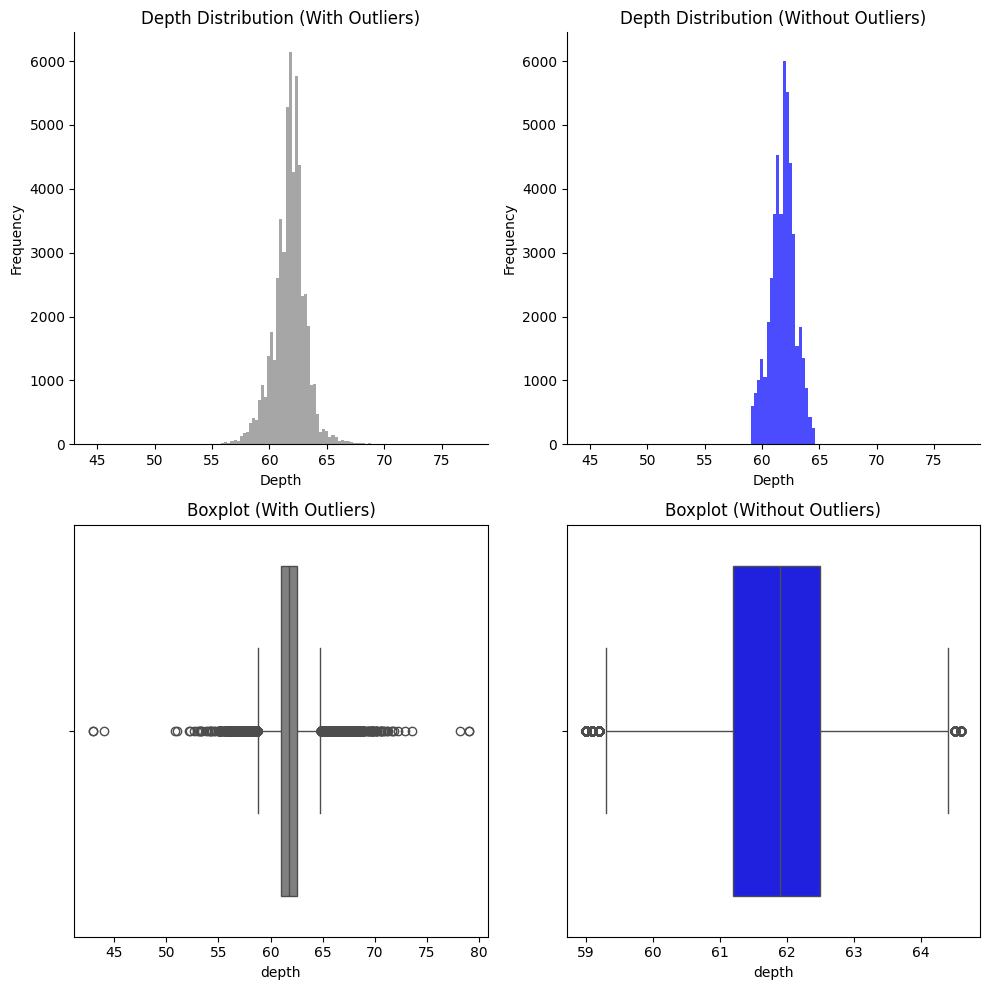

In [166]:
ig, ax = plt.subplots(2, 2, figsize=(10, 10))

data['depth'].plot(kind='hist', bins=135, ax=ax[0, 0], color='gray', alpha=0.7)
ax[0, 0].set_title('Depth Distribution (With Outliers)')
ax[0, 0].set_xlabel('Depth')  # Add x-axis label
ax[0, 0].spines[['top', 'right']].set_visible(False)

new_data['depth'].plot(kind='hist', bins=20, ax=ax[0, 1], color='blue', alpha=0.7)
ax[0, 1].set_title('Depth Distribution (Without Outliers)')
ax[0, 1].set_xlabel('Depth')  # Add x-axis label
ax[0, 1].spines[['top', 'right']].set_visible(False)

x_min = min(data['depth'].min(), new_data['depth'].min())
x_max = max(data['depth'].max(), new_data['depth'].max())
y_min = 0
y_max = max(ax[0, 0].get_ylim()[1], ax[0,1].get_ylim()[1])

ax[0, 0].set_xlim(x_min, x_max)
ax[0, 1].set_xlim(x_min, x_max)
ax[0, 0].set_ylim(y_min, y_max)
ax[0, 1].set_ylim(y_min, y_max)

sns.boxplot(x=data['depth'], ax=ax[1, 0], color='gray')
ax[1, 0].set_title("Boxplot (With Outliers)")

sns.boxplot(x=new_data['depth'], ax=ax[1, 1], color='blue')
ax[1, 1].set_title("Boxplot (Without Outliers)")
plt.tight_layout()
plt.show()

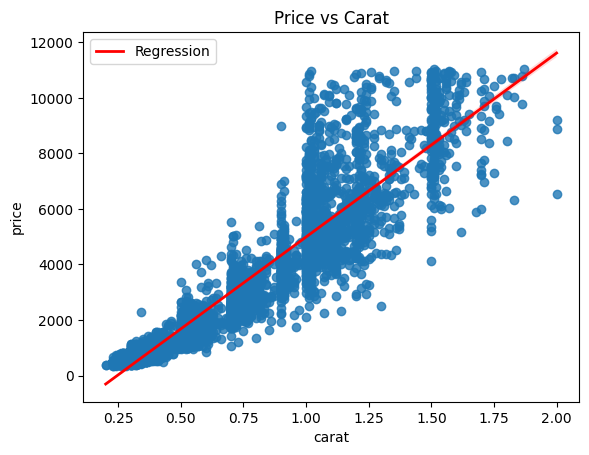

In [205]:
sample_data = new_data.sample(5000, random_state=42)
plt.title('Price vs Carat')
sns.regplot(x=sample_data.carat, y=sample_data.price, line_kws={'color': 'red', 'linewidth': 2})
plt.plot([], [], color='red', linewidth=2, label='Regression')
plt.legend()


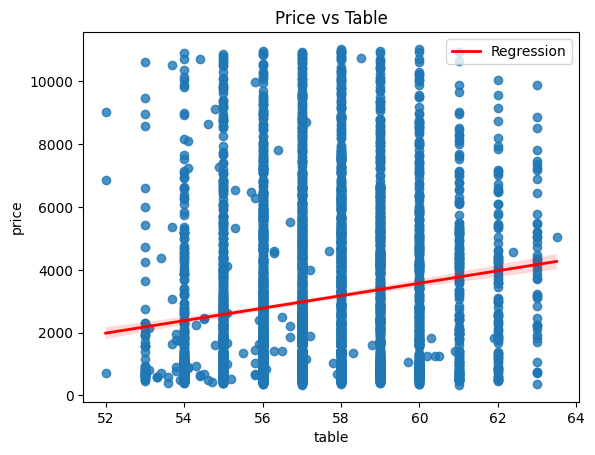

In [180]:
sample_data = new_data.sample(5000, random_state=42)
plt.title('Price vs Table')
sns.regplot(x=sample_data.table, y=sample_data.price, line_kws={'color': 'red', 'linewidth': 2})
plt.plot([], [], color='red', linewidth=2, label='Regression')
plt.legend()

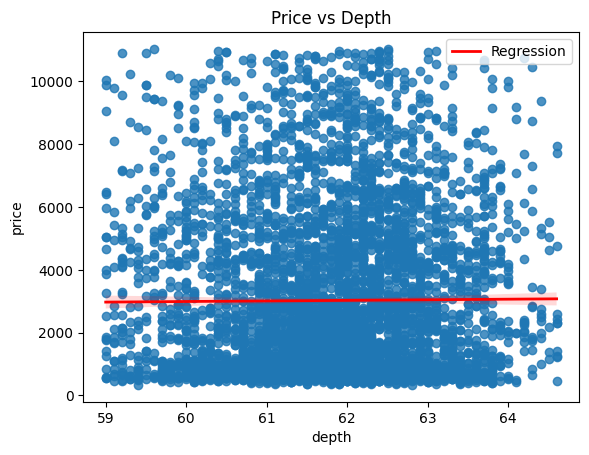

In [181]:
sample_data = new_data.sample(5000, random_state=42)
plt.title('Price vs Depth')
sns.regplot(x=sample_data.depth, y=sample_data.price, line_kws={'color': 'red', 'linewidth': 2})
plt.plot([], [], color='red', linewidth=2, label='Regression')
plt.legend()

### Spliting the dataset into X (features) and y (target variable).

In [167]:
X = new_data.drop(columns = ['price'])
y = new_data['price']

In [168]:
y.describe()

,price
count,46532.000000
mean,2999.000107
std,2598.654394
min,326.000000
25%,880.000000
50%,2002.500000
75%,4523.000000
max,11040.000000


### One-Hot Encoding of Categorical Features

In [169]:
# Identify categorical and numerical columns
s = (X.dtypes == 'object')
cat_cols = list(s[s].index)  # Categorical columns
num_cols = list(X.drop(columns=cat_cols).columns)  # Numerical columns

# Extract categorical and numerical data separately
X_categorical = X[cat_cols]
X_numerical = X[num_cols]

# Initialize and fit the OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = enc.fit_transform(X_categorical)

# Convert the encoded array to a DataFrame with proper column names
encoded_cols = enc.get_feature_names_out(cat_cols)  # Get feature names
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols, index=X.index)

# Concatenate numerical and encoded categorical columns
new_X = pd.concat([X_numerical, X_encoded_df], axis=1)
new_X.head()

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
1,0.23,61.5,55.0,3.95,3.98,2.43,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.21,59.8,61.0,3.89,3.84,2.31,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.29,62.4,58.0,4.20,4.23,2.63,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.31,63.3,58.0,4.34,4.35,2.75,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.24,62.8,57.0,3.94,3.96,2.48,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Spliting the X and y into train set and validation set

In [170]:
train_X, val_X, train_y, val_y = train_test_split(new_X, y, random_state = 0)

### Making and training Machine Learning model and printing the MAE for every model

In [172]:
model_DTR = DecisionTreeRegressor()
model_DTR.fit(train_X, train_y)


DecisionTreeRegressor()

In [173]:
predicted_prices_DTR = model_DTR.predict(val_X)
DTR_mean = mean_absolute_error(val_y, predicted_prices_DTR)
print(DTR_mean)

247.4914467463251


In [175]:
model_RFR = RandomForestRegressor()
model_RFR.fit(train_X, train_y)

RandomForestRegressor()

In [182]:
predicted_prices_RFR = model_RFR.predict(val_X)
RFR_mean = mean_absolute_error(val_y, predicted_prices_RFR)
print(RFR_mean)

191.6456608846754


In [183]:
model_LR = LinearRegression()
model_LR.fit(train_X, train_y)

LinearRegression()

In [184]:
predicted_prices_LR = model_LR.predict(val_X)
LR_mean = mean_absolute_error(val_y, predicted_prices_LR)
print(LR_mean)

478.2707575099852


In [185]:
model_XGB = XGBRegressor()
model_XGB.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [186]:
predicted_prices_XGB = model_XGB.predict(val_X)
XGB_mean = mean_absolute_error(val_y, predicted_prices_XGB)
print(XGB_mean)

198.1331787109375


In [187]:
XGB_means = []
r = 0
LRs = [0.01, 0.05, 0.1, 0.2]
NEs = [10, 100, 1000, 2000]
MDs = [3, 5, 8, 10]
for lr in LRs:
    for ne in NEs:
        for md in MDs:
            print(f'{r}/63')
            model = XGBRegressor(learning_rate = lr, n_estimators=ne, max_depth = md, early_stopping_rounds = 10, eval_metric="mae")
            model.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)
            preds = model.predict(val_X)
            mean = mean_absolute_error(preds, val_y)
            XGB_means.append({'learning rate':lr, 'n_estimators':ne, 'max depth':md, 'MAE': mean})
            r +=1


0/63
1/63
2/63
3/63
4/63
5/63
6/63
7/63
8/63
9/63
10/63
11/63
12/63
13/63
14/63
15/63
16/63
17/63
18/63
19/63
20/63
21/63
22/63
23/63
24/63
25/63
26/63
27/63
28/63
29/63
30/63
31/63
32/63
33/63
34/63
35/63
36/63
37/63
38/63
39/63
40/63
41/63
42/63
43/63
44/63
45/63
46/63
47/63
48/63
49/63
50/63
51/63
52/63
53/63
54/63
55/63
56/63
57/63
58/63
59/63
60/63
61/63
62/63
63/63


In [188]:
df_means = pd.DataFrame(XGB_means)

df_sorted = df_means.sort_values(by='MAE', ascending=True)
df_sorted.head()

,learning rate,n_estimators,max depth,MAE
43,0.10,1000,10,185.630569
47,0.10,2000,10,185.630569
27,0.05,1000,10,185.964005
31,0.05,2000,10,185.964005
14,0.01,2000,8,186.484177


<Axes: xlabel='learning rate', ylabel='MAE'>

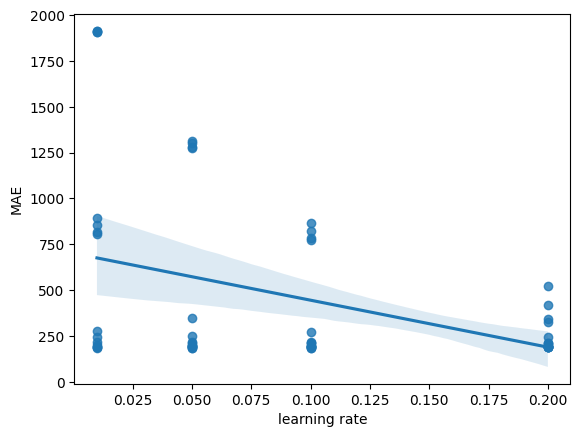

In [189]:
sns.regplot(x='learning rate', y='MAE', data = df_means)

<Axes: xlabel='max depth', ylabel='MAE'>

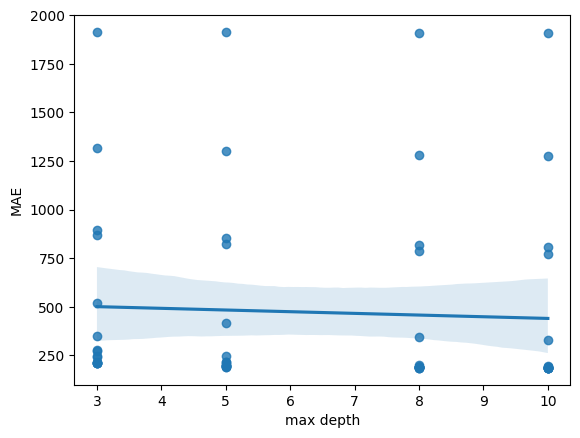

In [190]:
sns.regplot(x='max depth', y='MAE', data = df_means)

<Axes: xlabel='n_estimators', ylabel='MAE'>

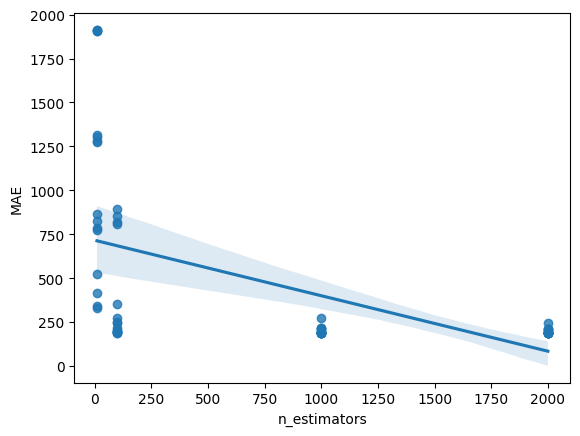

In [191]:
sns.regplot(x='n_estimators', y='MAE', data = df_means)

BEST: 0.01	1000	10	185,63

In [192]:
best_XGB_model = XGBRegressor(learning_rate = 0.1, n_estimators=1000, max_depth = 10, early_stopping_rounds = 10, eval_metric="mae")
model.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)
predicted_prices_best_XGB= model.predict(val_X)
best_XGB_mean = mean_absolute_error(predicted_prices_best_XGB, val_y)

### Ploting the MAE/RMAE/R2 results for every model

In [193]:
means = [RFR_mean, XGB_mean, best_XGB_mean, DTR_mean, LR_mean]

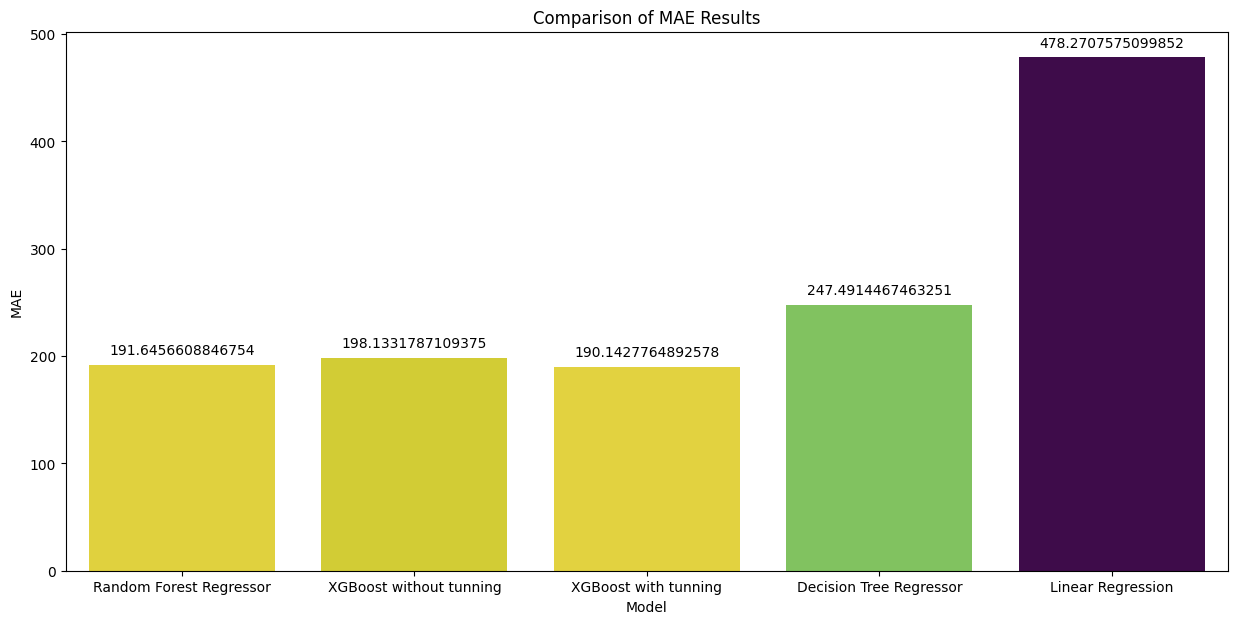

In [194]:
plt.figure(figsize=(15, 7))
models = ['Random Forest Regressor', 'XGBoost without tunning', 'XGBoost with tunning', 'Decision Tree Regressor', 'Linear Regression']
sns.barplot(x=models, y=means, palette='viridis_r',hue = means, legend=False)
#plt.grid(axis='y')
for i, value in enumerate(means):
    plt.text(i, value + 20, f'{value}', ha='center', va='top', fontsize=10)
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Comparison of MAE Results')
plt.show()

In [195]:
mean_act = val_y.mean()
rel_means = []
for m in means:
    rel_mean = (m/mean_act)*100
    rel_mean = rel_mean.round(2)
    rel_means.append(rel_mean)
rel_means

[np.float64(6.45),
 np.float64(6.67),
 np.float64(6.4),
 np.float64(8.33),
 np.float64(16.09)]

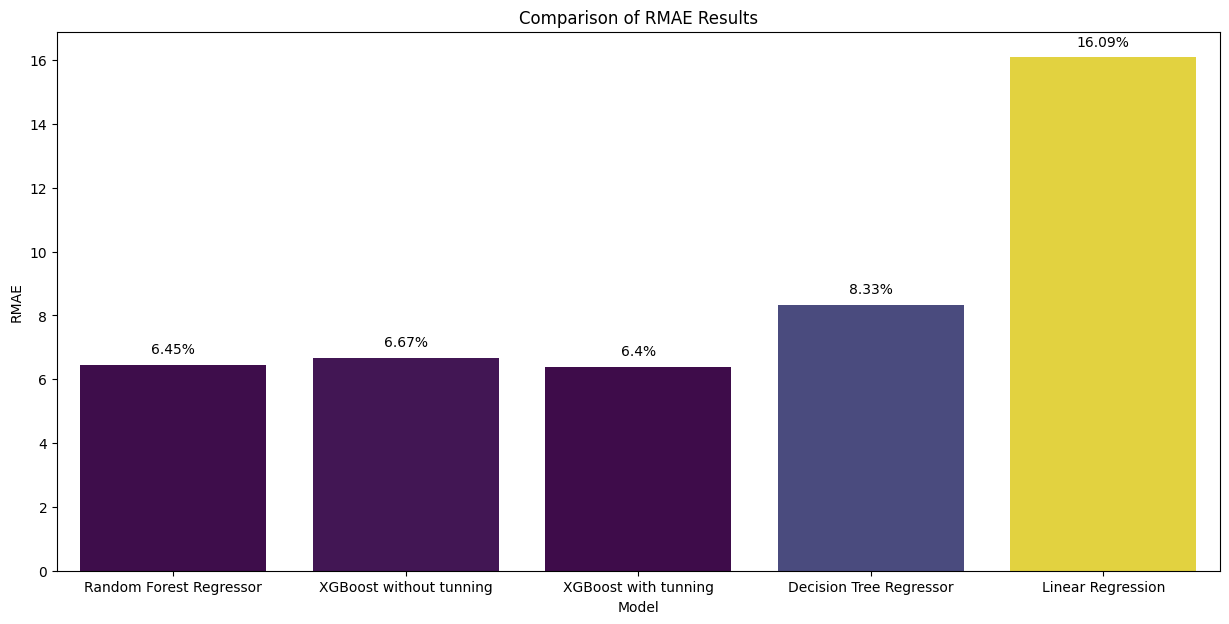

In [200]:
plt.figure(figsize=(15, 7))
models = ['Random Forest Regressor', 'XGBoost without tunning', 'XGBoost with tunning', 'Decision Tree Regressor', 'Linear Regression']
sns.barplot(x=models, y=rel_means, palette='viridis', hue=rel_means, legend=False)
#plt.grid(axis='y')
for i, value in enumerate(rel_means):
    plt.text(i, value+0.7, f'{value.round(2)}%', ha='center', va='top', fontsize=10)
plt.xlabel('Model')
plt.ylabel('RMAE')
plt.title('Comparison of RMAE Results')
plt.show()

In [197]:
pred_prices = [predicted_prices_RFR, predicted_prices_XGB, predicted_prices_best_XGB, predicted_prices_DTR, predicted_prices_LR]

In [198]:
r2s = []
for pred_price in pred_prices:
    r2 = r2_score(val_y, pred_price)
    r2s.append(r2)

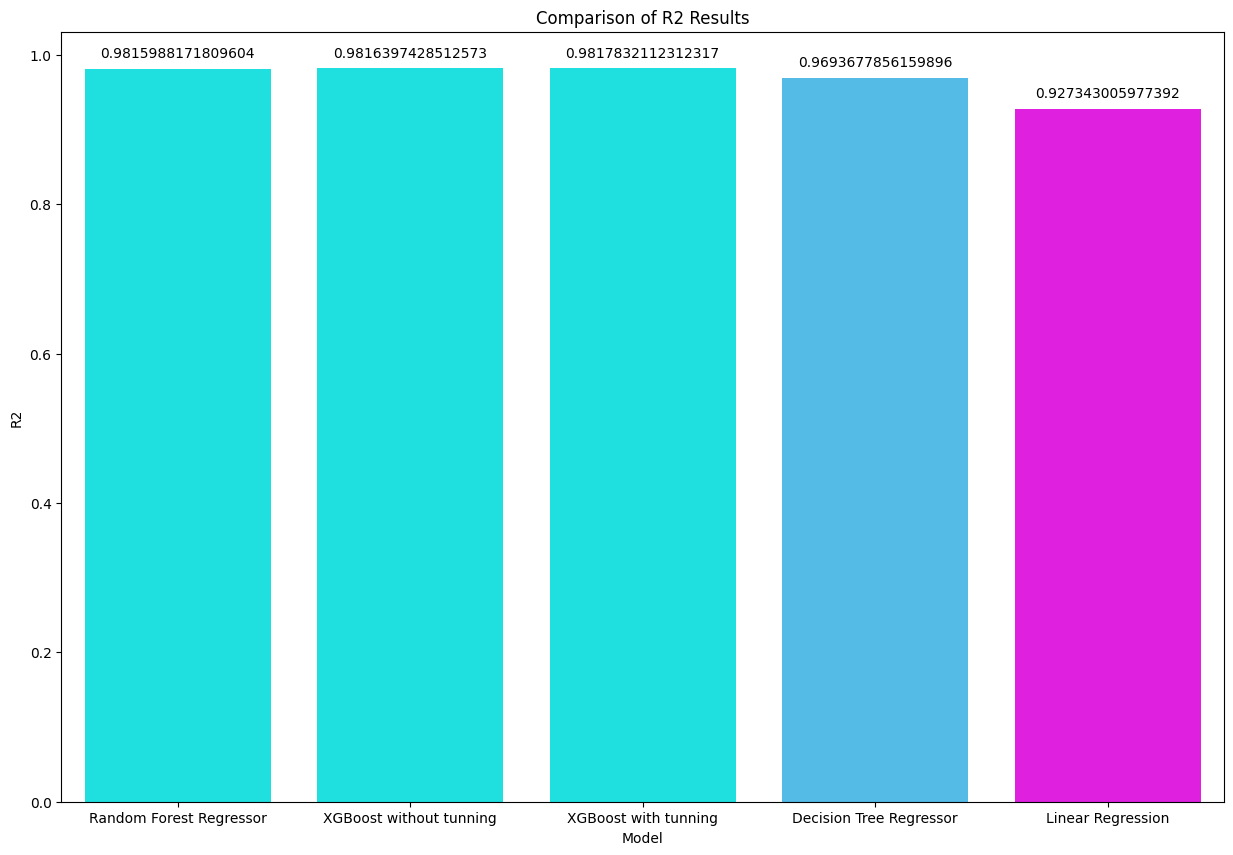

In [201]:
plt.figure(figsize=(15, 10))
models = ['Random Forest Regressor', 'XGBoost without tunning', 'XGBoost with tunning', 'Decision Tree Regressor', 'Linear Regression']
sns.barplot(x=models, y=r2s, palette='cool_r', hue=r2s, legend=False)
#plt.grid(axis='y')
for i, value in enumerate(r2s):
    plt.text(i, value+0.03, f'{value}', ha='center', va='top', fontsize=10)
plt.xlabel('Model')
plt.ylabel('R2')
plt.title('Comparison of R2 Results')
plt.show()

### Comparing the 3 best models

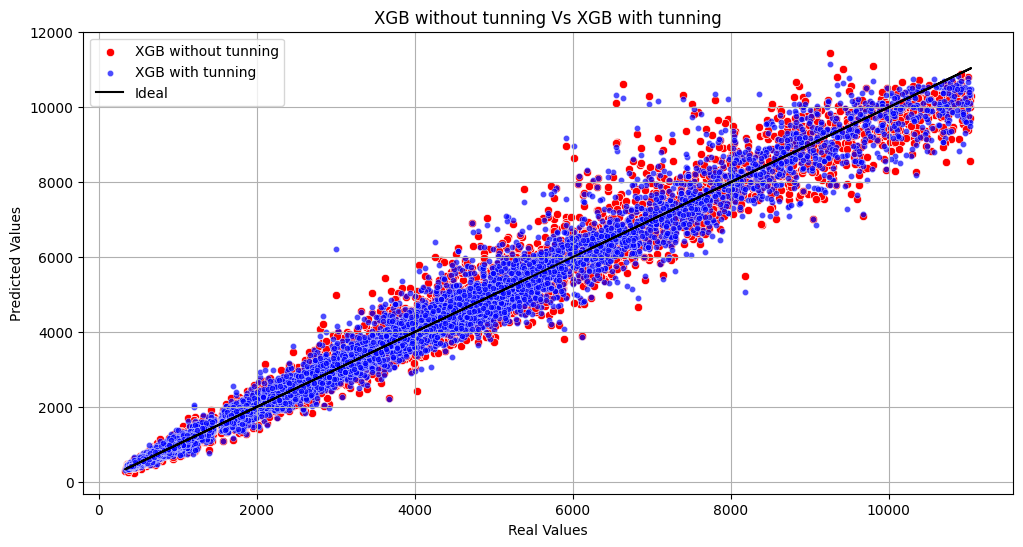

In [202]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=val_y, y=predicted_prices_XGB, label='XGB without tunning', color = 'red')
sns.scatterplot(x=val_y, y=predicted_prices_best_XGB, s = 20, alpha = 0.7, label='XGB with tunning', color = 'blue')
plt.grid()
plt.plot(val_y, val_y, color = 'black', label="Ideal")
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('XGB without tunning Vs XGB with tunning')
plt.legend()
plt.show()

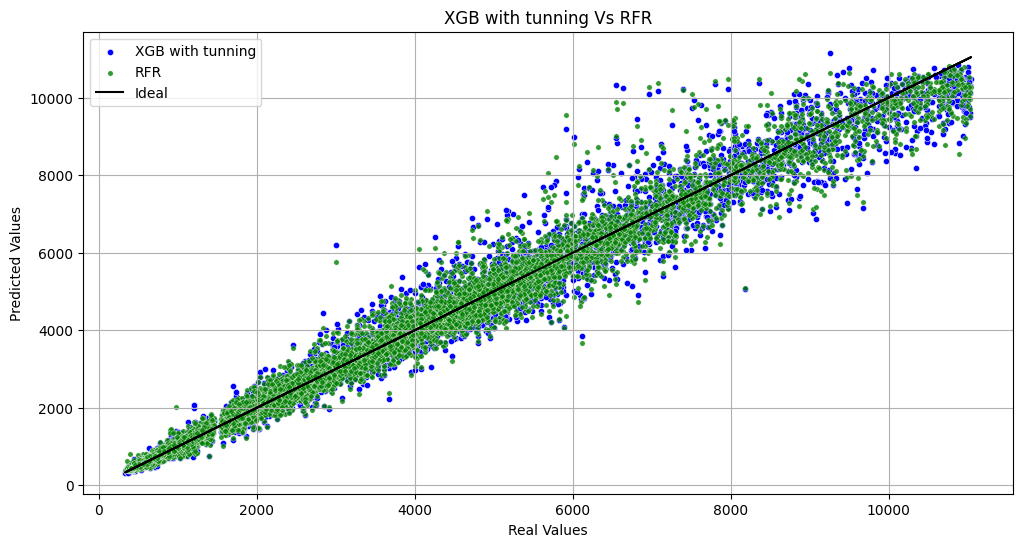

In [203]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=val_y, y=predicted_prices_best_XGB, s = 20, alpha = 1, label='XGB with tunning', color = 'blue')
sns.scatterplot(x=val_y, y=predicted_prices_RFR, s = 15, alpha = 0.8, label='RFR', color = 'green')
plt.grid()
plt.plot(val_y, val_y, color = 'black', label="Ideal")
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('XGB with tunning Vs RFR')
plt.legend()
plt.show()